<a href="https://colab.research.google.com/github/SourLemon23/brain-tumor-diagnosis/blob/master/resnet_brain_tumor_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [165]:
import os
import numpy as np
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
# ! pip install efficientnet
import efficientnet.tfkeras as efn
import matplotlib.pyplot as plt

In [166]:
# Authorize access to mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [167]:
# Initialize dataset directories (Google Drive)
training_dir   = r'/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/training'
validation_dir = r'/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/validation'
testing_dir    = r'/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing'

In [168]:
# Store all testing images in a list
testing_img_paths = []

for root, dirs, files in os.walk(testing_dir):
    for filename in files:
        testing_img_paths.append(os.path.abspath(os.path.join(root, filename)))

# Randomize the list
random.shuffle(testing_img_paths)

In [169]:
# Initialize constants
classes = ['glioma', 'meningioma', 'pituitary']
img_width, img_height = 150, 150
target_size = (img_width, img_height)
input_shape = (img_width, img_height, 3)

batch_size = 20
epochs = 100

In [170]:
# Augment data
training_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                       rescale=1./255,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       zoom_range=0.15,
                                       shear_range=0.15,
                                       rotation_range=360,
                                       width_shift_range=0.15,
                                       height_shift_range=0.15,
                                       validation_split=0.15)

validation_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                         rescale=1./255)

In [171]:
# Split data
training_generator = training_data_gen.flow_from_directory(training_dir,
                                                           target_size=target_size,
                                                           class_mode='categorical',
                                                           batch_size=batch_size,
                                                           shuffle=True)

validation_generator = validation_data_gen.flow_from_directory(validation_dir,
                                                               target_size=target_size,
                                                               class_mode='categorical',
                                                               batch_size=batch_size,
                                                               shuffle=False)

Found 2460 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [172]:
# Create a neural network
def create_model():
    model = Sequential()

    model.add(ResNet50(include_top=False, weights='imagenet', input_shape=input_shape))
    model.add(Dropout(0.5))

    model.add(Conv2D(16, (3, 3), activation = 'relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (3, 3), activation = 'relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(training_generator.num_classes, activation='softmax'))

    return model

In [173]:
# Print an overall summary of the model
def print_model_summary(model):
    model.summary()

In [174]:
# Configure model
def compile_model(model):
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [175]:
# Train the model
def fit_model(model):
    history = model.fit(training_generator,
                        epochs=epochs,
                        steps_per_epoch=(training_generator.n/batch_size),
                        validation_data=validation_generator,
                        validation_steps=(validation_generator.n/batch_size))
    
    return history

In [176]:
# Plot and evaluate the model
def evaluate_model(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

In [177]:
# Classify a tumor from an MRI scan
def classify_tumor(model, testing_img_paths):
    for i, img_path in enumerate(testing_img_paths):
        img = load_img(
            img_path,
            target_size=target_size)

        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        img_array = img_array.reshape((-1, 150, 150, 3))

        predictions = model.predict(img_array)
        class_num = predictions.argmax()

        network_percent_confidence = str(np.max(predictions) * 100)[:4] + '%'
        network_prediction = classes[class_num].capitalize()

        print(f'MRI Scan #{i+1})')

        font = {'family': 'DejaVu Sans',
                'color' : 'red',
                'weight': 'heavy',
                'size'  :  10}
        
        plt.imshow(img)
        plt.title(f'Network Prediction: {network_prediction} ({network_percent_confidence})', fontdict=font)
        plt.show()

In [178]:
model = create_model()
compile_model(model)
print_model_summary(model)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
dropout_9 (Dropout)          (None, 5, 5, 2048)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 16)          294928    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 3, 3, 16)          64        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 32)          4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 2, 2, 32)         

Epoch 1/100
123/123 [==============================] - 30s 244ms/step - loss: 0.6652 - accuracy: 0.7394 - val_loss: 1.8501 - val_accuracy: 0.4067
Epoch 2/100
123/123 [==============================] - 29s 234ms/step - loss: 0.4694 - accuracy: 0.8175 - val_loss: 1.3440 - val_accuracy: 0.3267
Epoch 3/100
123/123 [==============================] - 29s 235ms/step - loss: 0.4798 - accuracy: 0.8150 - val_loss: 1.0888 - val_accuracy: 0.4667
Epoch 4/100
123/123 [==============================] - 29s 234ms/step - loss: 0.4152 - accuracy: 0.8309 - val_loss: 2.4019 - val_accuracy: 0.3333
Epoch 5/100
123/123 [==============================] - 29s 236ms/step - loss: 0.3446 - accuracy: 0.8744 - val_loss: 6.4757 - val_accuracy: 0.3333
Epoch 6/100
123/123 [==============================] - 29s 234ms/step - loss: 0.3703 - accuracy: 0.8654 - val_loss: 2.3909 - val_accuracy: 0.3533
Epoch 7/100
123/123 [==============================] - 29s 235ms/step - loss: 0.3376 - accuracy: 0.8756 - val_loss: 3.2473 -

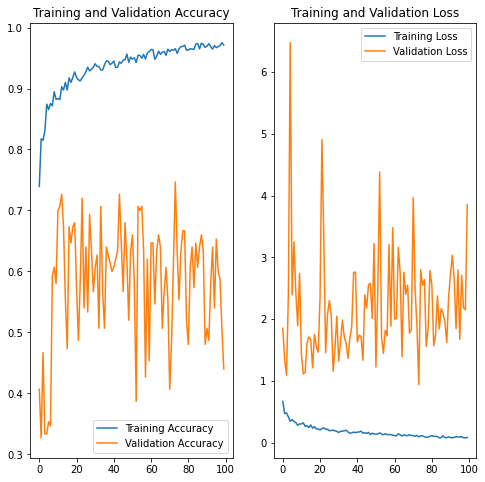

In [179]:
history = fit_model(model)
evaluate_model(history)

MRI Scan #1)


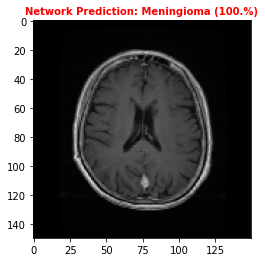

MRI Scan #2)


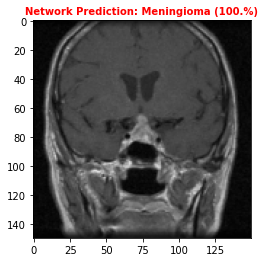

MRI Scan #3)


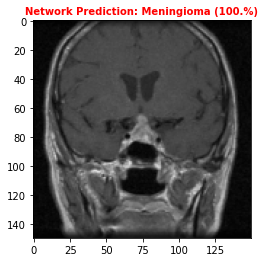

MRI Scan #4)


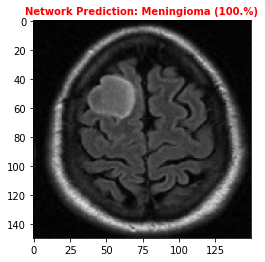

MRI Scan #5)


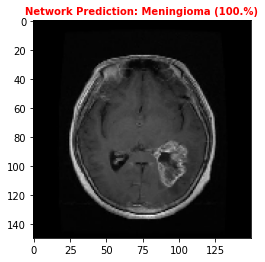

MRI Scan #6)


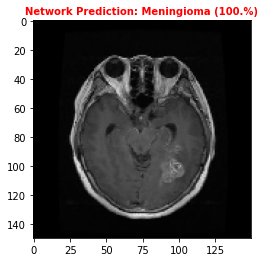

MRI Scan #7)


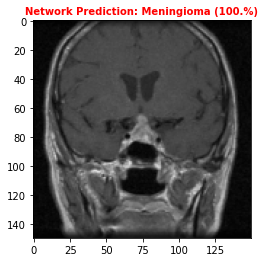

MRI Scan #8)


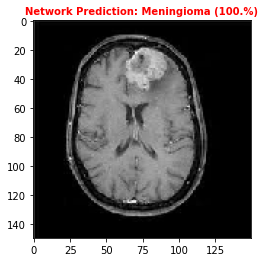

MRI Scan #9)


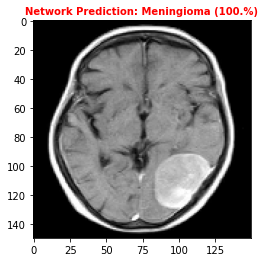

MRI Scan #10)


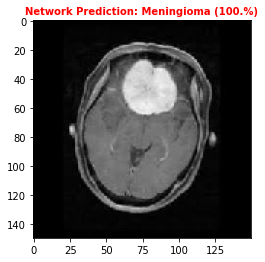

MRI Scan #11)


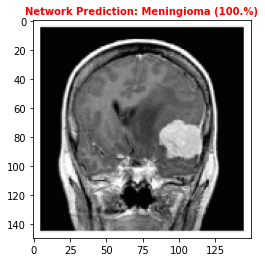

MRI Scan #12)


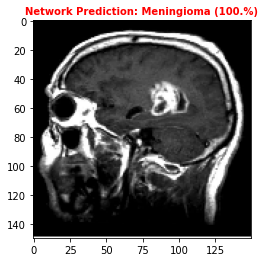

MRI Scan #13)


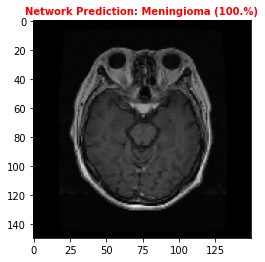

MRI Scan #14)


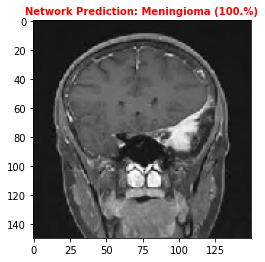

MRI Scan #15)


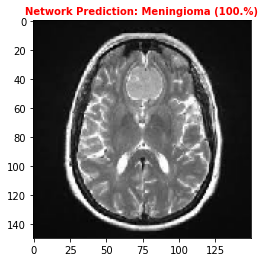

MRI Scan #16)


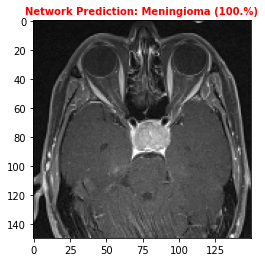

MRI Scan #17)


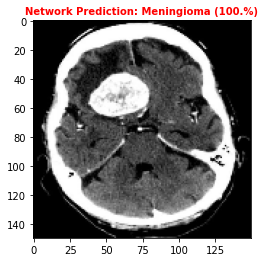

MRI Scan #18)


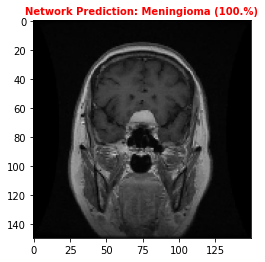

MRI Scan #19)


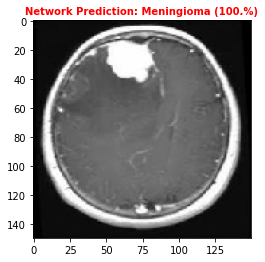

MRI Scan #20)


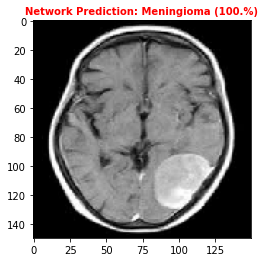

MRI Scan #21)


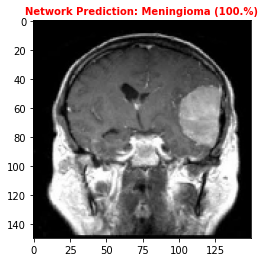

MRI Scan #22)


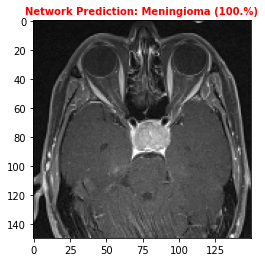

MRI Scan #23)


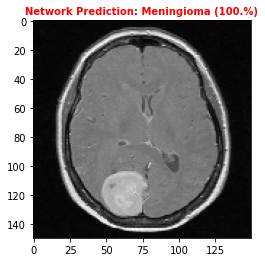

MRI Scan #24)


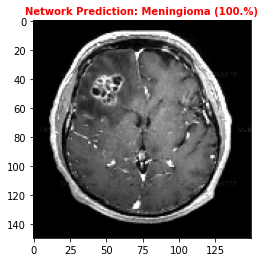

MRI Scan #25)


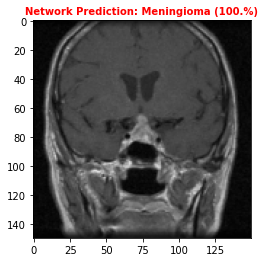

MRI Scan #26)


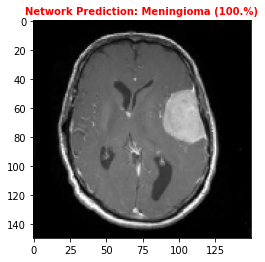

MRI Scan #27)


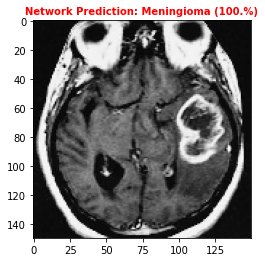

MRI Scan #28)


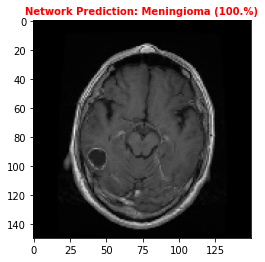

MRI Scan #29)


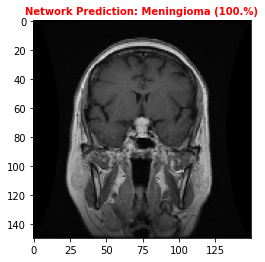

MRI Scan #30)


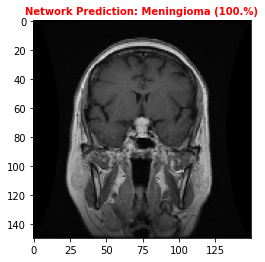

MRI Scan #31)


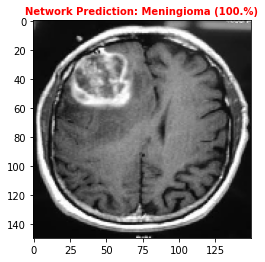

MRI Scan #32)


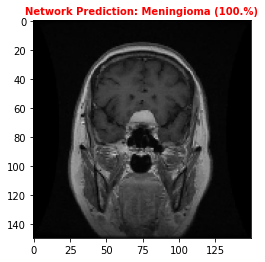

MRI Scan #33)


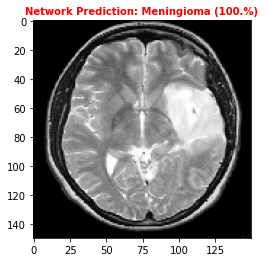

MRI Scan #34)


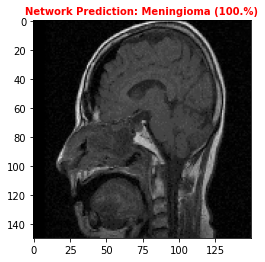

MRI Scan #35)


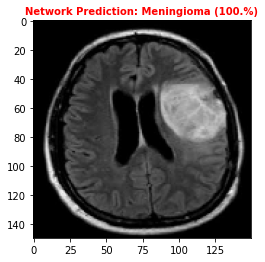

MRI Scan #36)


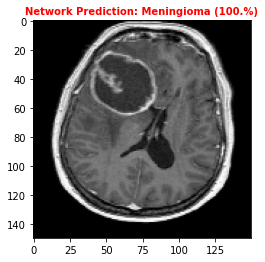

MRI Scan #37)


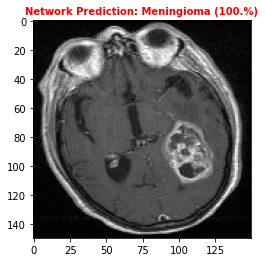

MRI Scan #38)


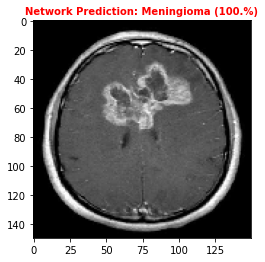

MRI Scan #39)


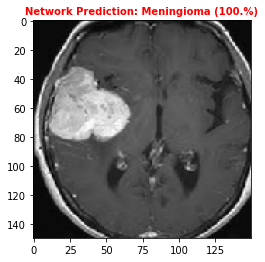

MRI Scan #40)


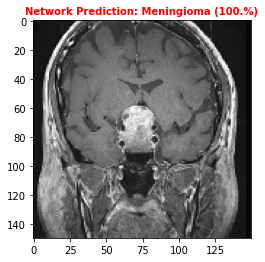

MRI Scan #41)


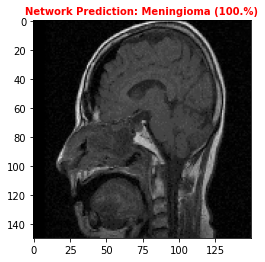

MRI Scan #42)


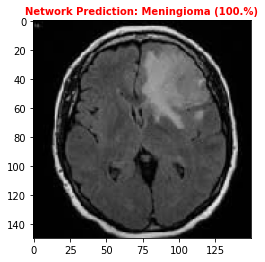

MRI Scan #43)


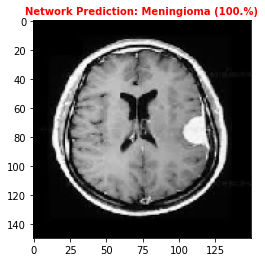

MRI Scan #44)


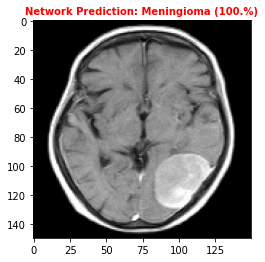

MRI Scan #45)


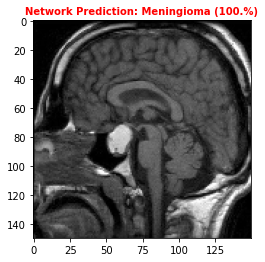

MRI Scan #46)


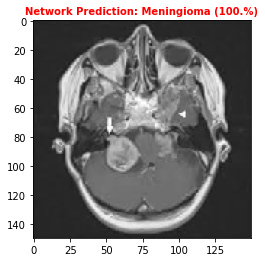

MRI Scan #47)


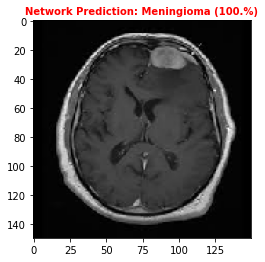

MRI Scan #48)


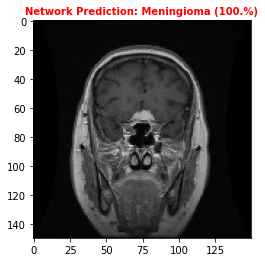

MRI Scan #49)


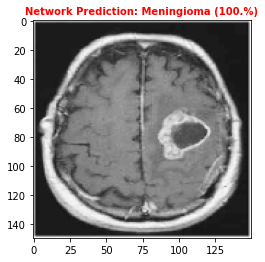

MRI Scan #50)


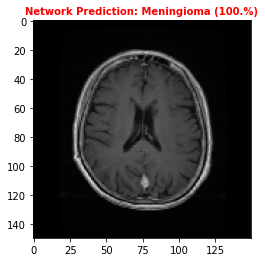

MRI Scan #51)


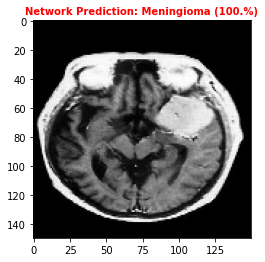

MRI Scan #52)


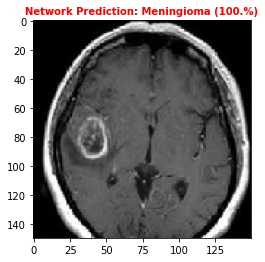

MRI Scan #53)


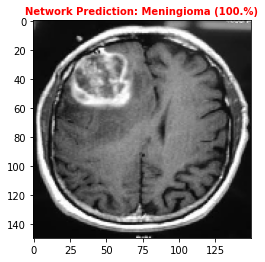

MRI Scan #54)


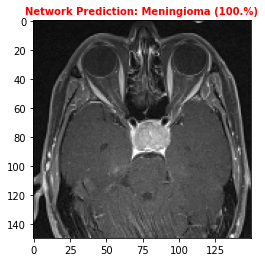

MRI Scan #55)


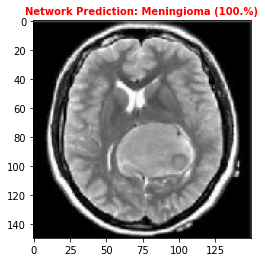

MRI Scan #56)


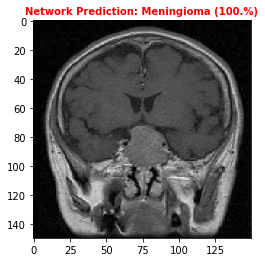

MRI Scan #57)


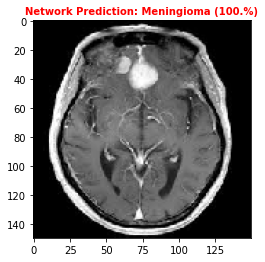

MRI Scan #58)


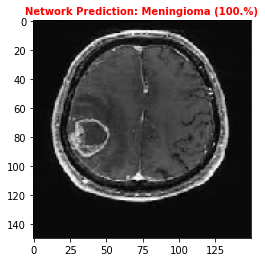

MRI Scan #59)


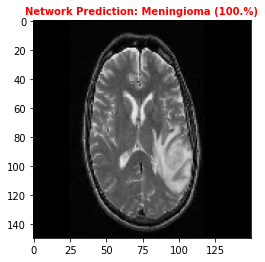

MRI Scan #60)


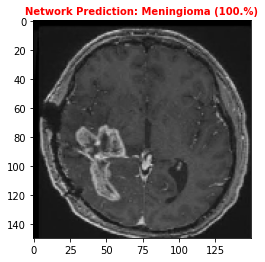

In [180]:
classify_tumor(model, testing_img_paths)